In [29]:
import pandas as pd
import numpy as np
import itertools as it

In [41]:
# Parameters
hash_function = "murmur2"

baseline_recommendations_path = "../data/baseline_recommendations.json"
single_partition_recommendations_path = "../data/single_recommendations.json"
recommendations_path = f"../data/{hash_function}_recommendations.json"
merge_recommendations_path = f"../data/{hash_function}_merge_recommendations.json"

with_partitions = True

users = "../data/users.json"
output_map = f"../data/{hash_function}_map@k.json"
output_diagram = f"../output/{hash_function}_map@k.png"
output_map_at_10 = f"../output/{hash_function}_map@10.csv"

In [42]:
# Read data
baseline_df = pd.read_json(baseline_recommendations_path, orient="table")
single_partition_recommendations_df = pd.read_json(single_partition_recommendations_path, orient="table")

merge_recommendations_df = pd.read_json(merge_recommendations_path, orient="table")
partitioned_recommendations_df = pd.read_json(recommendations_path, orient="table")
partitioned_recommendations_df["len_recommendations"] = partitioned_recommendations_df["recommendations"].str.len()

user_ids = pd.read_json(users, orient="table")["user_id"].values

In [43]:
def apk(list_actual: list, list_predicted: list, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of
    items.
    Parameters
    ----------
    list_actual : list
             A list of elements that are to be predicted (order doesn't matter)
    list_predicted : list
             A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(list_predicted) > k:
        list_predicted = list_predicted[:min(len(list_actual), k)]

    sum_precision = 0.0
    num_hits = 0.0
    
    for i, prediction in enumerate(list_predicted):
        if prediction in list_actual and prediction not in list_predicted[:i]:
            num_hits += 1.0
            precision_at_i = num_hits / (i + 1.0)
            sum_precision += precision_at_i

    if not list_actual:
        return 0.0

    return sum_precision / min(len(list_actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average precision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [44]:
def calculate_map_k(df):
    list_actual = []
    list_prediction = []
    rows = []
    
    hash_fun = df["hash_function"].unique()[0]
    partitions = df["partition"].unique()
    partitions.sort()
    
    print(partitions)

    for partition in list(partitions):
        for k in range(1, 11):
            for _, uid in enumerate(user_ids):
                actual = baseline_df[baseline_df["user"]==uid]["recommendations"].values[0]

                con = (
                    (df["user"]==uid) & 
                    (df["partition"]==partition)
                )

                try:
                    predicted = df[con]["recommendations"].values[0]

                    list_actual.append(actual)
                    list_prediction.append(predicted)
                except IndexError as error:
                    print(f"userID {uid}, partition {partition}, hash_function {hash_fun}")

            m = mapk(list_actual, list_prediction, int(k))
            rows.append((hash_fun, partition, k, m))

            print(f"map@{k}: {m}    partition: {partition}    hash_function: {hash_fun}")

    return pd.DataFrame(rows, columns=["hash_function", "partition", "k", "map"])

In [45]:
# Calculate MAP@K for Single, Multi partition, and merged

mapk_single_df = calculate_map_k(single_partition_recommendations_df)

mapk_partitions_df = pd.DataFrame(columns=["hash_function", "partition", "k", "map"])
if with_partitions:
    mapk_partitions_df = calculate_map_k(partitioned_recommendations_df)

mapk_merge_df = calculate_map_k(merge_recommendations_df)

mapk_df = mapk_single_df.append([mapk_partitions_df, mapk_merge_df])
mapk_df.to_json(output_map, index=False, orient="table")
# mapk_single_df

['partition']
map@1: 0.0    partition: partition    hash_function: Single
map@2: 0.25    partition: partition    hash_function: Single
map@3: 0.16666666666666666    partition: partition    hash_function: Single
map@4: 0.125    partition: partition    hash_function: Single
map@5: 0.1    partition: partition    hash_function: Single
map@6: 0.13888888888888887    partition: partition    hash_function: Single
map@7: 0.14965986394557823    partition: partition    hash_function: Single
map@8: 0.16220238095238093    partition: partition    hash_function: Single
map@9: 0.14417989417989419    partition: partition    hash_function: Single
map@10: 0.12976190476190474    partition: partition    hash_function: Single
['0' '1']
map@1: 0.5    partition: 0    hash_function: murmur2
map@2: 0.25    partition: 0    hash_function: murmur2
map@3: 0.27777777777777773    partition: 0    hash_function: murmur2
map@4: 0.3333333333333333    partition: 0    hash_function: murmur2
map@5: 0.26666666666666666    pa

In [46]:
def draw_plot(mapk_df, plt):
    ax = plt.gca()

    hash_functions = mapk_df["hash_function"].unique()

    for func in list(hash_functions):
        df_partition = mapk_df[mapk_df["hash_function"] == func]
        
        partitions = df_partition["partition"].unique()
        partitions.sort()
        
        for partition in list(partitions):
            df = df_partition[df_partition["partition"] == partition]
            df.plot(x="k",
                    y='map', 
                    kind="line",
                    title=f"Mean Average Precision @ K for Increasing $K$ for {len(user_ids)} Users",
                    label=f"{func} {partition}",
                    marker='o',
                    ax=ax)

    ax.set_ylim([0,1])
    ax.set_xlabel("K")
    ax.set_ylabel("Mean Average Precision @ K")
    ax.set_title(f"Mean Average Precision @ K for Increasing $K$ for {len(user_ids)} Users")
    return plt

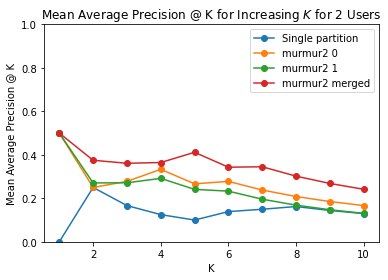

In [47]:
import matplotlib.pyplot as plt

plot = draw_plot(mapk_df, plt)
plot.savefig(output_diagram)

In [27]:
map_10_df = mapk_df[mapk_df["k"] == 10].reset_index(drop=True)
map_10_df.to_csv(output_map_at_10, index=False)